# Linear regression

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.3f}'.format)
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression ,Lasso , Ridge , ElasticNet ,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('Walmart_sales.csv')
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.900,0,42.310,2.572,211.096,8.106
1,1,12-02-2010,1641957.440,1,38.510,2.548,211.242,8.106
2,1,19-02-2010,1611968.170,0,39.930,2.514,211.289,8.106
3,1,26-02-2010,1409727.590,0,46.630,2.561,211.320,8.106
4,1,05-03-2010,1554806.680,0,46.500,2.625,211.350,8.106


In [4]:
df.shape

(6435, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [8]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year

print(f"The Data Has years : {df.year.unique()}")

day_of_week = df["Date"].dt.day_name().unique()
print(f"The Data Has all {day_of_week} value")

The Data Has years : [2010 2011 2012]
The Data Has all ['Friday'] value


In [9]:
df["Holiday_Flag"] = df["Holiday_Flag"].astype("object")
df["Holiday_Flag"].value_counts()


Holiday_Flag
0    5985
1     450
Name: count, dtype: int64

In [10]:
print("Total Stores ",":",len(df["Store"].unique()))

Total Stores  : 45


In [11]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'month', 'year'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   object        
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   month         6435 non-null   int32         
 9   year          6435 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 452.6+ KB


In [13]:
df.Store = df.Store.astype("object")

In [14]:
numerical_columns = df.select_dtypes(exclude = "object")
numerical_columns = numerical_columns.drop(columns = ["Date","month","year"]).columns
print(numerical_columns)

Index(['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], dtype='object')


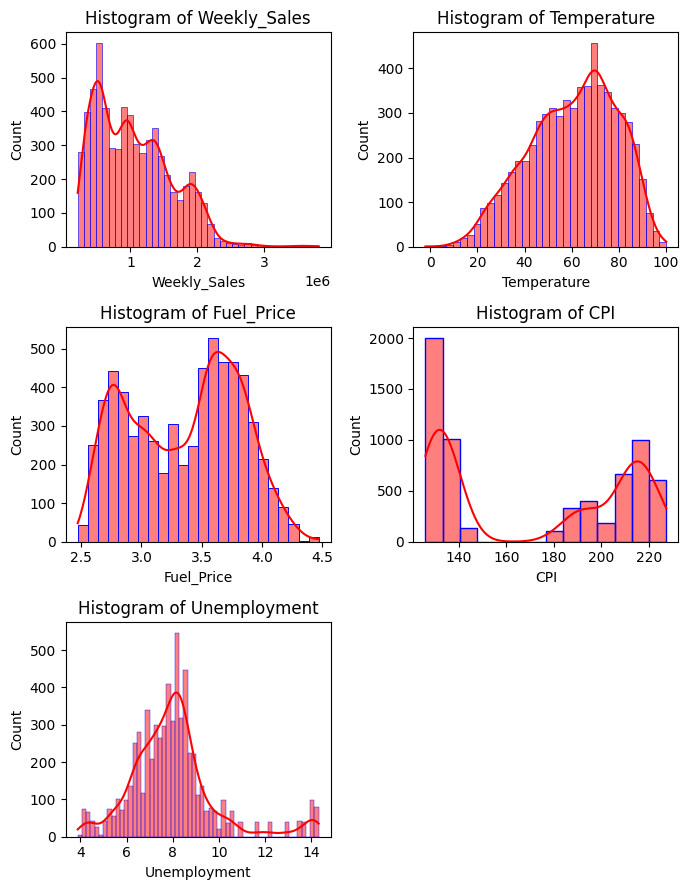

In [15]:
num_plots = len(numerical_columns)
num_rows = (num_plots + 1) // 2
num_cols = min(2, num_plots)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 3 * num_rows))

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color='red', edgecolor='blue')
    axes[i].set_title(f'Histogram of {column}')

# Hide empty subplots in the last row and column if necessary
for j in range(num_plots, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

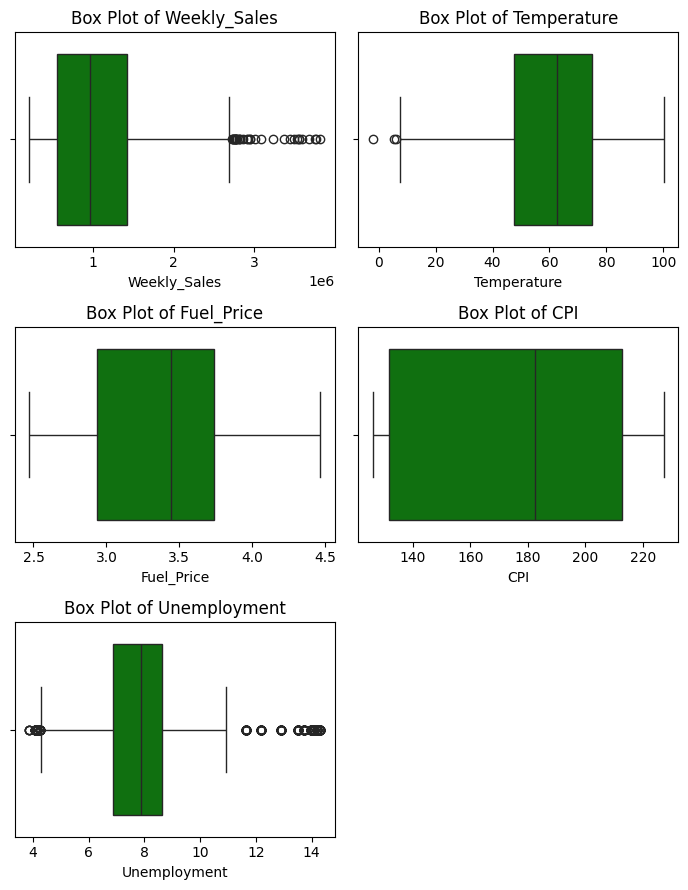

In [16]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 3 * num_rows))

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i], color='green')
    axes[i].set_title(f'Box Plot of {column}')

# Hide empty subplots in the last row and column if necessary
for j in range(num_plots, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [18]:
Q1 = np.percentile(df["Weekly_Sales"],25)  
Q3 = np.percentile(df["Weekly_Sales"],75)   
print("Q1:",Q1,"&","Q3:",Q3)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


Q1: 553350.105 & Q3: 1420158.66


<AxesSubplot: >

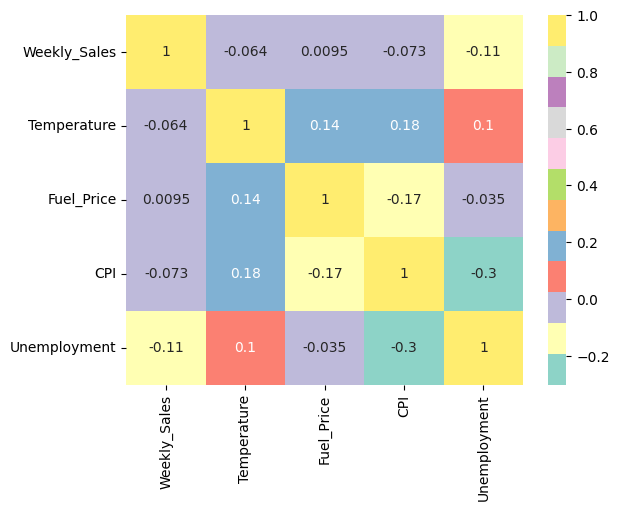

In [19]:
df_corr = df[numerical_columns].corr()
sns.heatmap(df_corr, annot = True , cmap = "Set3")

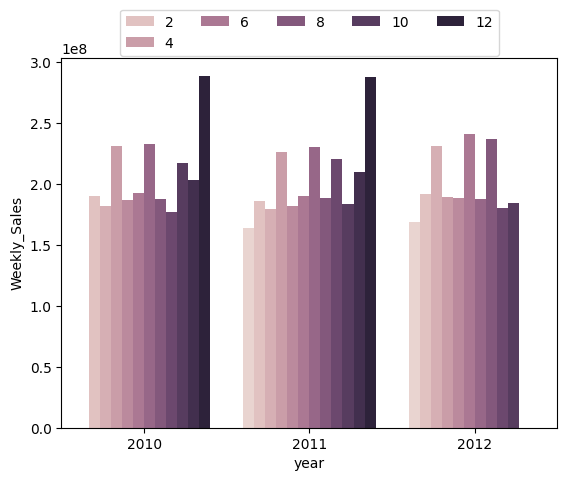

In [20]:
sns.barplot(data =df , x ="year" , y="Weekly_Sales" ,estimator = np.sum , hue ="month",ci = None)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5) 

In [21]:
df_year = df.groupby(["year","month"])["Weekly_Sales"].sum().reset_index()
crosstab_df = pd.crosstab(index=df_year["month"], columns=df_year["year"], values=df_year["Weekly_Sales"], aggfunc='sum')
crosstab_df = crosstab_df.sort_index(ascending=False)
crosstab_df

year,2010,2011,2012
month,,,
12,288760532.720,288078102.480,NaN
11,202853370.140,210162354.870,NaN
10,217161824.020,183261283.150,184361680.420
9,177267896.370,220847738.420,180645544.470
8,187640110.890,188599332.250,236850765.680
7,232580125.980,229911398.870,187509452.400
6,192246172.360,189773385.190,240610329.290
5,186710934.340,181648158.160,188766479.450
4,231412368.050,226526510.970,188920905.950


In [22]:
ss = StandardScaler()

df_original = df

In [23]:
df.drop(columns = "Date" ,inplace = True)

In [24]:
df["month"] = df["month"].astype("object")
df["year"] = df["year"].astype("object")
x = df.drop(columns = "Weekly_Sales")
y = df["Weekly_Sales"]
categorical_columns = x.select_dtypes("object").columns
numerical_columns = x.select_dtypes(exclude = "object").columns
print("numerical columns are:",numerical_columns)
print("categorical columns are:",categorical_columns)

numerical columns are: Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], dtype='object')
categorical columns are: Index(['Store', 'Holiday_Flag', 'month', 'year'], dtype='object')


In [25]:
num_transformed = ss.fit_transform(x[numerical_columns])
df_num = pd.DataFrame(num_transformed)
df_num.columns = numerical_columns
df_num

,Temperature,Fuel_Price,CPI,Unemployment
0,-0.995,-1.714,1.004,0.057
1,-1.201,-1.766,1.008,0.057
2,-1.124,-1.840,1.009,0.057
3,-0.761,-1.738,1.010,0.057
4,-0.768,-1.598,1.011,0.057
...,...,...,...,...
6430,0.229,1.391,0.519,0.365
6431,0.229,1.365,0.523,0.356
6432,-0.336,1.397,0.527,0.356
6433,-0.227,1.330,0.527,0.356


In [26]:
le = LabelEncoder()
ohe = OneHotEncoder()
binary = BinaryEncoder()
df_store= binary.fit_transform(x["Store"])
df_cat = pd.DataFrame(x["Holiday_Flag"].astype("int"))
df_cat["month"] = le.fit_transform(x["month"])
df_cat["year"] = le.fit_transform(x["year"])
df_cat = pd.concat([df_store ,df_cat],axis =1)
df_new = pd.concat([df_cat,df_num],axis =1)
X = df_new.copy()

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2, random_state = 30)


In [28]:
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((5148, 13), (1287, 13), (5148,), (1287,))

In [29]:
lr = LinearRegression()
rf = RandomForestRegressor()
dtr = DecisionTreeRegressor()
lasso = Lasso()
ridge = Ridge()
Elas =ElasticNet()
sgd = SGDRegressor()

def model_fit(*models):
    df_res = pd.DataFrame()
    for model in models:
        print("*****", model.__class__.__name__, "*****")
        print("\n")
        res = model.fit(xtrain,ytrain)
    
        test_pred = res.predict(xtest)
        train_pred = res.predict(xtrain)
    
        train_rmse = mean_squared_error(ytrain, train_pred, squared=False)
        test_rmse = mean_squared_error(ytest, test_pred, squared=False)
   
        train_r2score = r2_score(ytrain, train_pred)
        test_r2score = r2_score(ytest, test_pred)
        print("Metrics of Training SET")
        print("\n")
        print("RMSE :" , train_rmse)
        print("R2SCORE :", train_r2score )
        print("\n")
        print("Metrics of Test SET")
        print("\n")
        print("RMSE :" , test_rmse)
        print("R2SCORE :", test_r2score)
        print("\n")
        df_res[model.__class__.__name__+ "_test_pred"] = test_pred
    return df_res
model_eval = model_fit(lr,rf,dtr,sgd)

***** LinearRegression *****


Metrics of Training SET


RMSE : 506343.7131578393
R2SCORE : 0.20126077312885782


Metrics of Test SET


RMSE : 497586.10919750686
R2SCORE : 0.19706001844625098


***** RandomForestRegressor *****


Metrics of Training SET


RMSE : 48151.32956621514
R2SCORE : 0.9927767817654348


Metrics of Test SET


RMSE : 138661.18780169848
R2SCORE : 0.9376471340214796


***** DecisionTreeRegressor *****


Metrics of Training SET


RMSE : 0.0
R2SCORE : 1.0


Metrics of Test SET


RMSE : 179300.0634594013
R2SCORE : 0.8957424597511636


***** SGDRegressor *****


Metrics of Training SET


RMSE : 514984.4406269594
R2SCORE : 0.17376728892321558


Metrics of Test SET


RMSE : 507840.34203859564
R2SCORE : 0.16362511532304713




In [30]:
model_eval

,LinearRegression_test_pred,RandomForestRegressor_test_pred,DecisionTreeRegressor_test_pred,SGDRegressor_test_pred
0,1113019.155,1516864.468,1577541.240,1177850.912
1,525191.639,813066.462,822569.160,607941.327
2,1420479.733,2169570.226,2048613.650,1501362.095
3,882328.029,964018.553,900646.940,861823.787
4,1348405.242,2149600.069,2054843.280,1428716.533
...,...,...,...,...
1282,1261789.234,636575.092,592369.220,1353771.813
1283,932148.123,416395.485,435401.640,1078128.797
1284,983686.662,1478987.619,1459601.170,982796.805
1285,753542.147,1140843.771,1121756.430,837024.800


In [31]:
poly = PolynomialFeatures()

param_grid_poly = {
    'degree': [2, 3, 4]
}
grid_search_poly = GridSearchCV(poly, param_grid_poly, cv=5, scoring='r2')
grid_search_lr = GridSearchCV(lr, {}, cv=5, scoring='r2')
grid_search_poly.fit(xtrain)

GridSearchCV(cv=5, estimator=PolynomialFeatures(),
             param_grid={'degree': [2, 3, 4]}, scoring='r2')

In [32]:
best_degree = grid_search_poly.best_params_["degree"]

poly = PolynomialFeatures(degree=best_degree)
xtrain_poly = poly.fit_transform(xtrain)

grid_search_lr.fit(xtrain_poly, ytrain)
best_estimator = grid_search_lr.best_estimator_

xtest_poly = poly.fit_transform(xtest)
y_pred_poly_tuning = best_estimator.predict(xtest_poly)
model_eval.columns

Index(['LinearRegression_test_pred', 'RandomForestRegressor_test_pred',
       'DecisionTreeRegressor_test_pred', 'SGDRegressor_test_pred'],
      dtype='object')

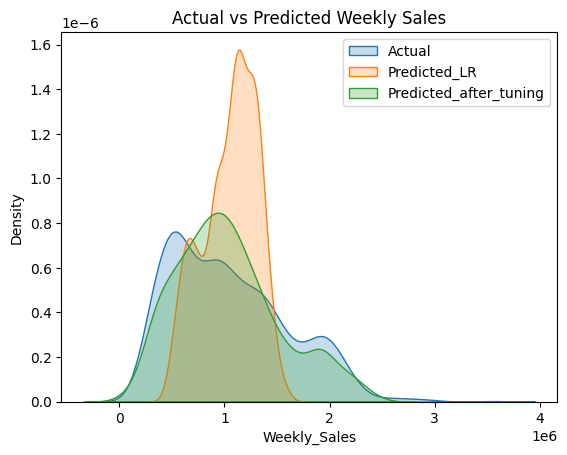

In [33]:
sns.kdeplot(data=ytest, label='Actual', shade=True)
sns.kdeplot(data=model_eval["LinearRegression_test_pred"], label='Predicted_LR', shade=True)
sns.kdeplot(data=y_pred_poly_tuning, label='Predicted_after_tuning', shade=True)

plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.show()

In [34]:
test_pred = best_estimator.predict(xtest_poly)
train_pred = best_estimator.predict(xtrain_poly)
        
train_rmse = mean_squared_error(ytrain, train_pred, squared=False)
test_rmse = mean_squared_error(ytest, test_pred, squared=False)
   
train_r2score = r2_score(ytrain, train_pred)
test_r2score = r2_score(ytest, test_pred)
print("Best Parameters:", grid_search_poly.best_params_)
print("**********")
print("Metrics of Training SET")
print("RMSE:", train_rmse)
print("R2SCORE:", train_r2score)
print("**********")
print("Metrics of Test SET")
print("RMSE:", test_rmse)
print("R2SCORE:", test_r2score)

Best Parameters: {'degree': 2}
**********
Metrics of Training SET
RMSE: 258720.395761883
R2SCORE: 0.7914666580769022
**********
Metrics of Test SET
RMSE: 261921.17584846116
R2SCORE: 0.7775216210959772


# Logistic regression

In [45]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [47]:
df = pd.read_csv('Social_Network_Ads.csv')
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [48]:
df=df.iloc[:,2:]
df.sample(5)

,Age,EstimatedSalary,Purchased
4,19,76000,0
176,35,47000,0
142,35,59000,0
143,30,89000,0
165,18,86000,0


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Purchased', axis=1),
                                                    df['Purchased'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((280, 2), (120, 2))

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
scaler.mean_

array([3.78642857e+01, 6.98071429e+04])

In [52]:
X_train

,Age,EstimatedSalary
92,26,15000
223,60,102000
234,38,112000
232,40,107000
377,42,53000
...,...,...
323,48,30000
192,29,43000
117,36,52000
47,27,54000


In [53]:
X_train_scaled

array([[-1.1631724 , -1.5849703 ],
       [ 2.17018137,  0.93098672],
       [ 0.0133054 ,  1.22017719],
       [ 0.20938504,  1.07558195],
       [ 0.40546467, -0.48604654],
       [-0.28081405, -0.31253226],
       [ 0.99370357, -0.8330751 ],
       [ 0.99370357,  1.8563962 ],
       [ 0.0133054 ,  1.24909623],
       [-0.86905295,  2.26126285],
       [-1.1631724 , -1.5849703 ],
       [ 2.17018137, -0.80415605],
       [-1.35925203, -1.46929411],
       [ 0.40546467,  2.2901819 ],
       [ 0.79762394,  0.75747245],
       [-0.96709276, -0.31253226],
       [ 0.11134522,  0.75747245],
       [-0.96709276,  0.55503912],
       [ 0.30742485,  0.06341534],
       [ 0.69958412, -1.26686079],
       [-0.47689368, -0.0233418 ],
       [-1.7514113 ,  0.3526058 ],
       [-0.67297331,  0.12125343],
       [ 0.40546467,  0.29476771],
       [-0.28081405,  0.06341534],
       [-0.47689368,  2.2901819 ],
       [ 0.20938504,  0.03449629],
       [ 1.28782302,  2.20342476],
       [ 0.79762394,

In [54]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [55]:
np.round(X_train.describe(), 1)

,Age,EstimatedSalary
count,280.000,280.000
mean,37.900,69807.100
std,10.200,34641.200
min,18.000,15000.000
25%,30.000,43000.000
50%,37.000,70500.000
75%,46.000,88000.000
max,60.000,150000.000


In [56]:
np.round(X_train_scaled.describe(), 1)

,Age,EstimatedSalary
count,280.000,280.000
mean,0.000,0.000
std,1.000,1.000
min,-1.900,-1.600
25%,-0.800,-0.800
50%,-0.100,0.000
75%,0.800,0.500
max,2.200,2.300


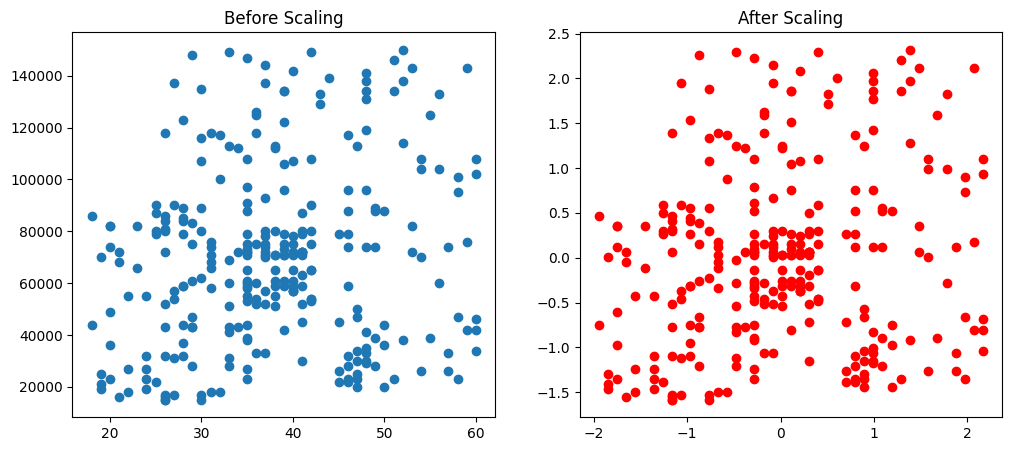

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.scatter(X_train['Age'], X_train['EstimatedSalary'])
ax1.set_title("Before Scaling")
ax2.scatter(X_train_scaled['Age'], X_train_scaled['EstimatedSalary'],color='red')
ax2.set_title("After Scaling")
plt.show()

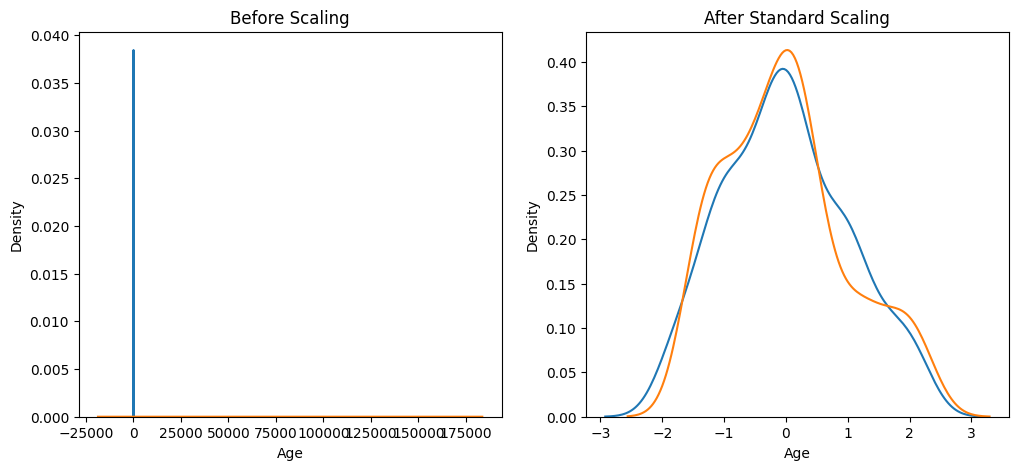

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(X_train['Age'], ax=ax1)
sns.kdeplot(X_train['EstimatedSalary'], ax=ax1)

ax2.set_title('After Standard Scaling')
sns.kdeplot(X_train_scaled['Age'], ax=ax2)
sns.kdeplot(X_train_scaled['EstimatedSalary'], ax=ax2)
plt.show()

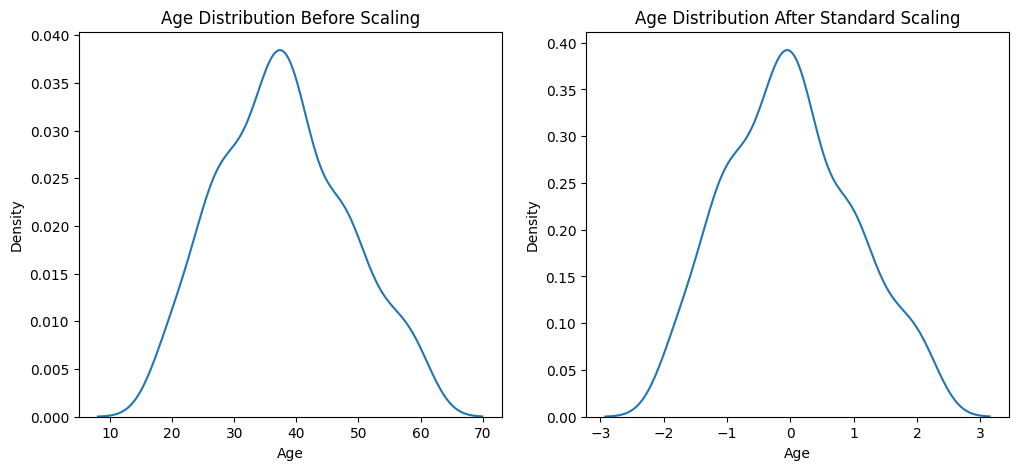

In [59]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title('Age Distribution Before Scaling')
sns.kdeplot(X_train['Age'], ax=ax1)

ax2.set_title('Age Distribution After Standard Scaling')
sns.kdeplot(X_train_scaled['Age'], ax=ax2)
plt.show()

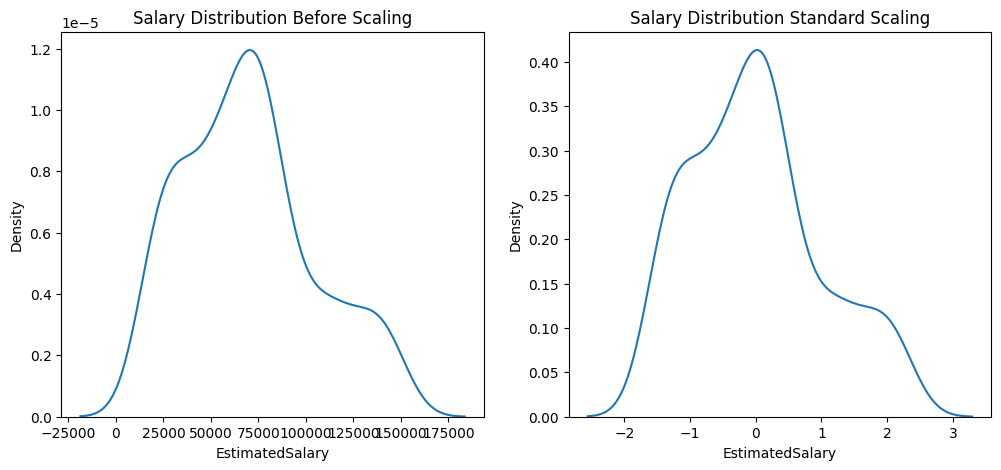

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title('Salary Distribution Before Scaling')
sns.kdeplot(X_train['EstimatedSalary'], ax=ax1)

ax2.set_title('Salary Distribution Standard Scaling')
sns.kdeplot(X_train_scaled['EstimatedSalary'], ax=ax2)
plt.show()

In [62]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_scaled = LogisticRegression()
lr.fit(X_train,y_train)
lr_scaled.fit(X_train_scaled,y_train)

LogisticRegression()

In [63]:
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)
from sklearn.metrics import accuracy_score
print("Actual",accuracy_score(y_test,y_pred))
print("Scaled",accuracy_score(y_test,y_pred_scaled))


Actual 0.875
Scaled 0.8666666666666667


In [64]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_scaled = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_scaled.fit(X_train_scaled,y_train)

DecisionTreeClassifier()

In [65]:
y_pred = dt.predict(X_test)
y_pred_scaled = dt_scaled.predict(X_test_scaled)
print("Actual",accuracy_score(y_test,y_pred))
print("Scaled",accuracy_score(y_test,y_pred_scaled))

Actual 0.875
Scaled 0.875


In [66]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000,400.000,400.000
mean,37.655,69742.500,0.357
std,10.483,34096.960,0.480
min,18.000,15000.000,0.000
25%,29.750,43000.000,0.000
50%,37.000,70000.000,0.000
75%,46.000,88000.000,1.000
max,60.000,150000.000,1.000


# Clustering

In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [69]:
customer_data = pd.read_csv("Customer_Data.csv")
customer_data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.901,0.818,95.400,0.000,95.400,0.000,0.167,0.000,0.083,0.000,0,2,1000.000,201.802,139.510,0.000,12
1,C10002,3202.467,0.909,0.000,0.000,0.000,6442.945,0.000,0.000,0.000,0.250,4,0,7000.000,4103.033,1072.340,0.222,12
2,C10003,2495.149,1.000,773.170,773.170,0.000,0.000,1.000,1.000,0.000,0.000,0,12,7500.000,622.067,627.285,0.000,12
3,C10004,1666.671,0.636,1499.000,1499.000,0.000,205.788,0.083,0.083,0.000,0.083,1,1,7500.000,0.000,NaN,0.000,12
4,C10005,817.714,1.000,16.000,16.000,0.000,0.000,0.083,0.083,0.000,0.000,0,1,1200.000,678.335,244.791,0.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.494,1.000,291.120,0.000,291.120,0.000,1.000,0.000,0.833,0.000,0,6,1000.000,325.594,48.886,0.500,6
8946,C19187,19.183,1.000,300.000,0.000,300.000,0.000,1.000,0.000,0.833,0.000,0,6,1000.000,275.861,NaN,0.000,6
8947,C19188,23.399,0.833,144.400,0.000,144.400,0.000,0.833,0.000,0.667,0.000,0,5,1000.000,81.271,82.418,0.250,6
8948,C19189,13.458,0.833,0.000,0.000,0.000,36.559,0.000,0.000,0.000,0.167,2,0,500.000,52.550,55.756,0.250,6


In [70]:
from itertools import product
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator

In [71]:
import warnings
warnings.filterwarnings('ignore')

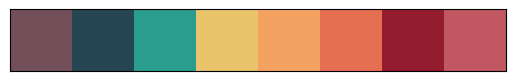

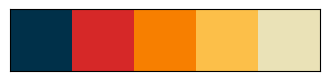

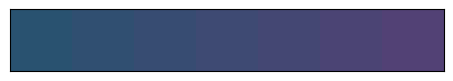

In [72]:
def my_palette(my_colors):
    myPalette = sns.set_palette(sns.color_palette(my_colors))
    sns.palplot(sns.color_palette(my_colors), size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

# Implementing FONT for the titles of the plots
FONT = {'fontsize':25, 'fontstyle':'normal', 'fontfamily':'Georgia', 'backgroundcolor':'#B41B10', 'color':'#E4C09E'}

# Creating color palette
colors1 = ["#734F5A", "#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51", "#941C2F", "#C05761"]
colors2 = ["#003049","#D62828","#F77F00","#FCBF49","#EAE2B7"]
dark_colors = ["#295270", "#304F71", "#374C72", "#3E4A73", "#444773", "#4B4474", "#524175"]

for color in [colors1, colors2, dark_colors]:
    my_palette(color)

In [73]:
df = pd.DataFrame(pd.read_csv("Customer_Data.csv"))
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.901,0.818,95.400,0.000,95.400,0.000,0.167,0.000,0.083,0.000,0,2,1000.000,201.802,139.510,0.000,12
1,C10002,3202.467,0.909,0.000,0.000,0.000,6442.945,0.000,0.000,0.000,0.250,4,0,7000.000,4103.033,1072.340,0.222,12
2,C10003,2495.149,1.000,773.170,773.170,0.000,0.000,1.000,1.000,0.000,0.000,0,12,7500.000,622.067,627.285,0.000,12
3,C10004,1666.671,0.636,1499.000,1499.000,0.000,205.788,0.083,0.083,0.000,0.083,1,1,7500.000,0.000,NaN,0.000,12
4,C10005,817.714,1.000,16.000,16.000,0.000,0.000,0.083,0.083,0.000,0.000,0,1,1200.000,678.335,244.791,0.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.494,1.000,291.120,0.000,291.120,0.000,1.000,0.000,0.833,0.000,0,6,1000.000,325.594,48.886,0.500,6
8946,C19187,19.183,1.000,300.000,0.000,300.000,0.000,1.000,0.000,0.833,0.000,0,6,1000.000,275.861,NaN,0.000,6
8947,C19188,23.399,0.833,144.400,0.000,144.400,0.000,0.833,0.000,0.667,0.000,0,5,1000.000,81.271,82.418,0.250,6
8948,C19189,13.458,0.833,0.000,0.000,0.000,36.559,0.000,0.000,0.000,0.167,2,0,500.000,52.550,55.756,0.250,6


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

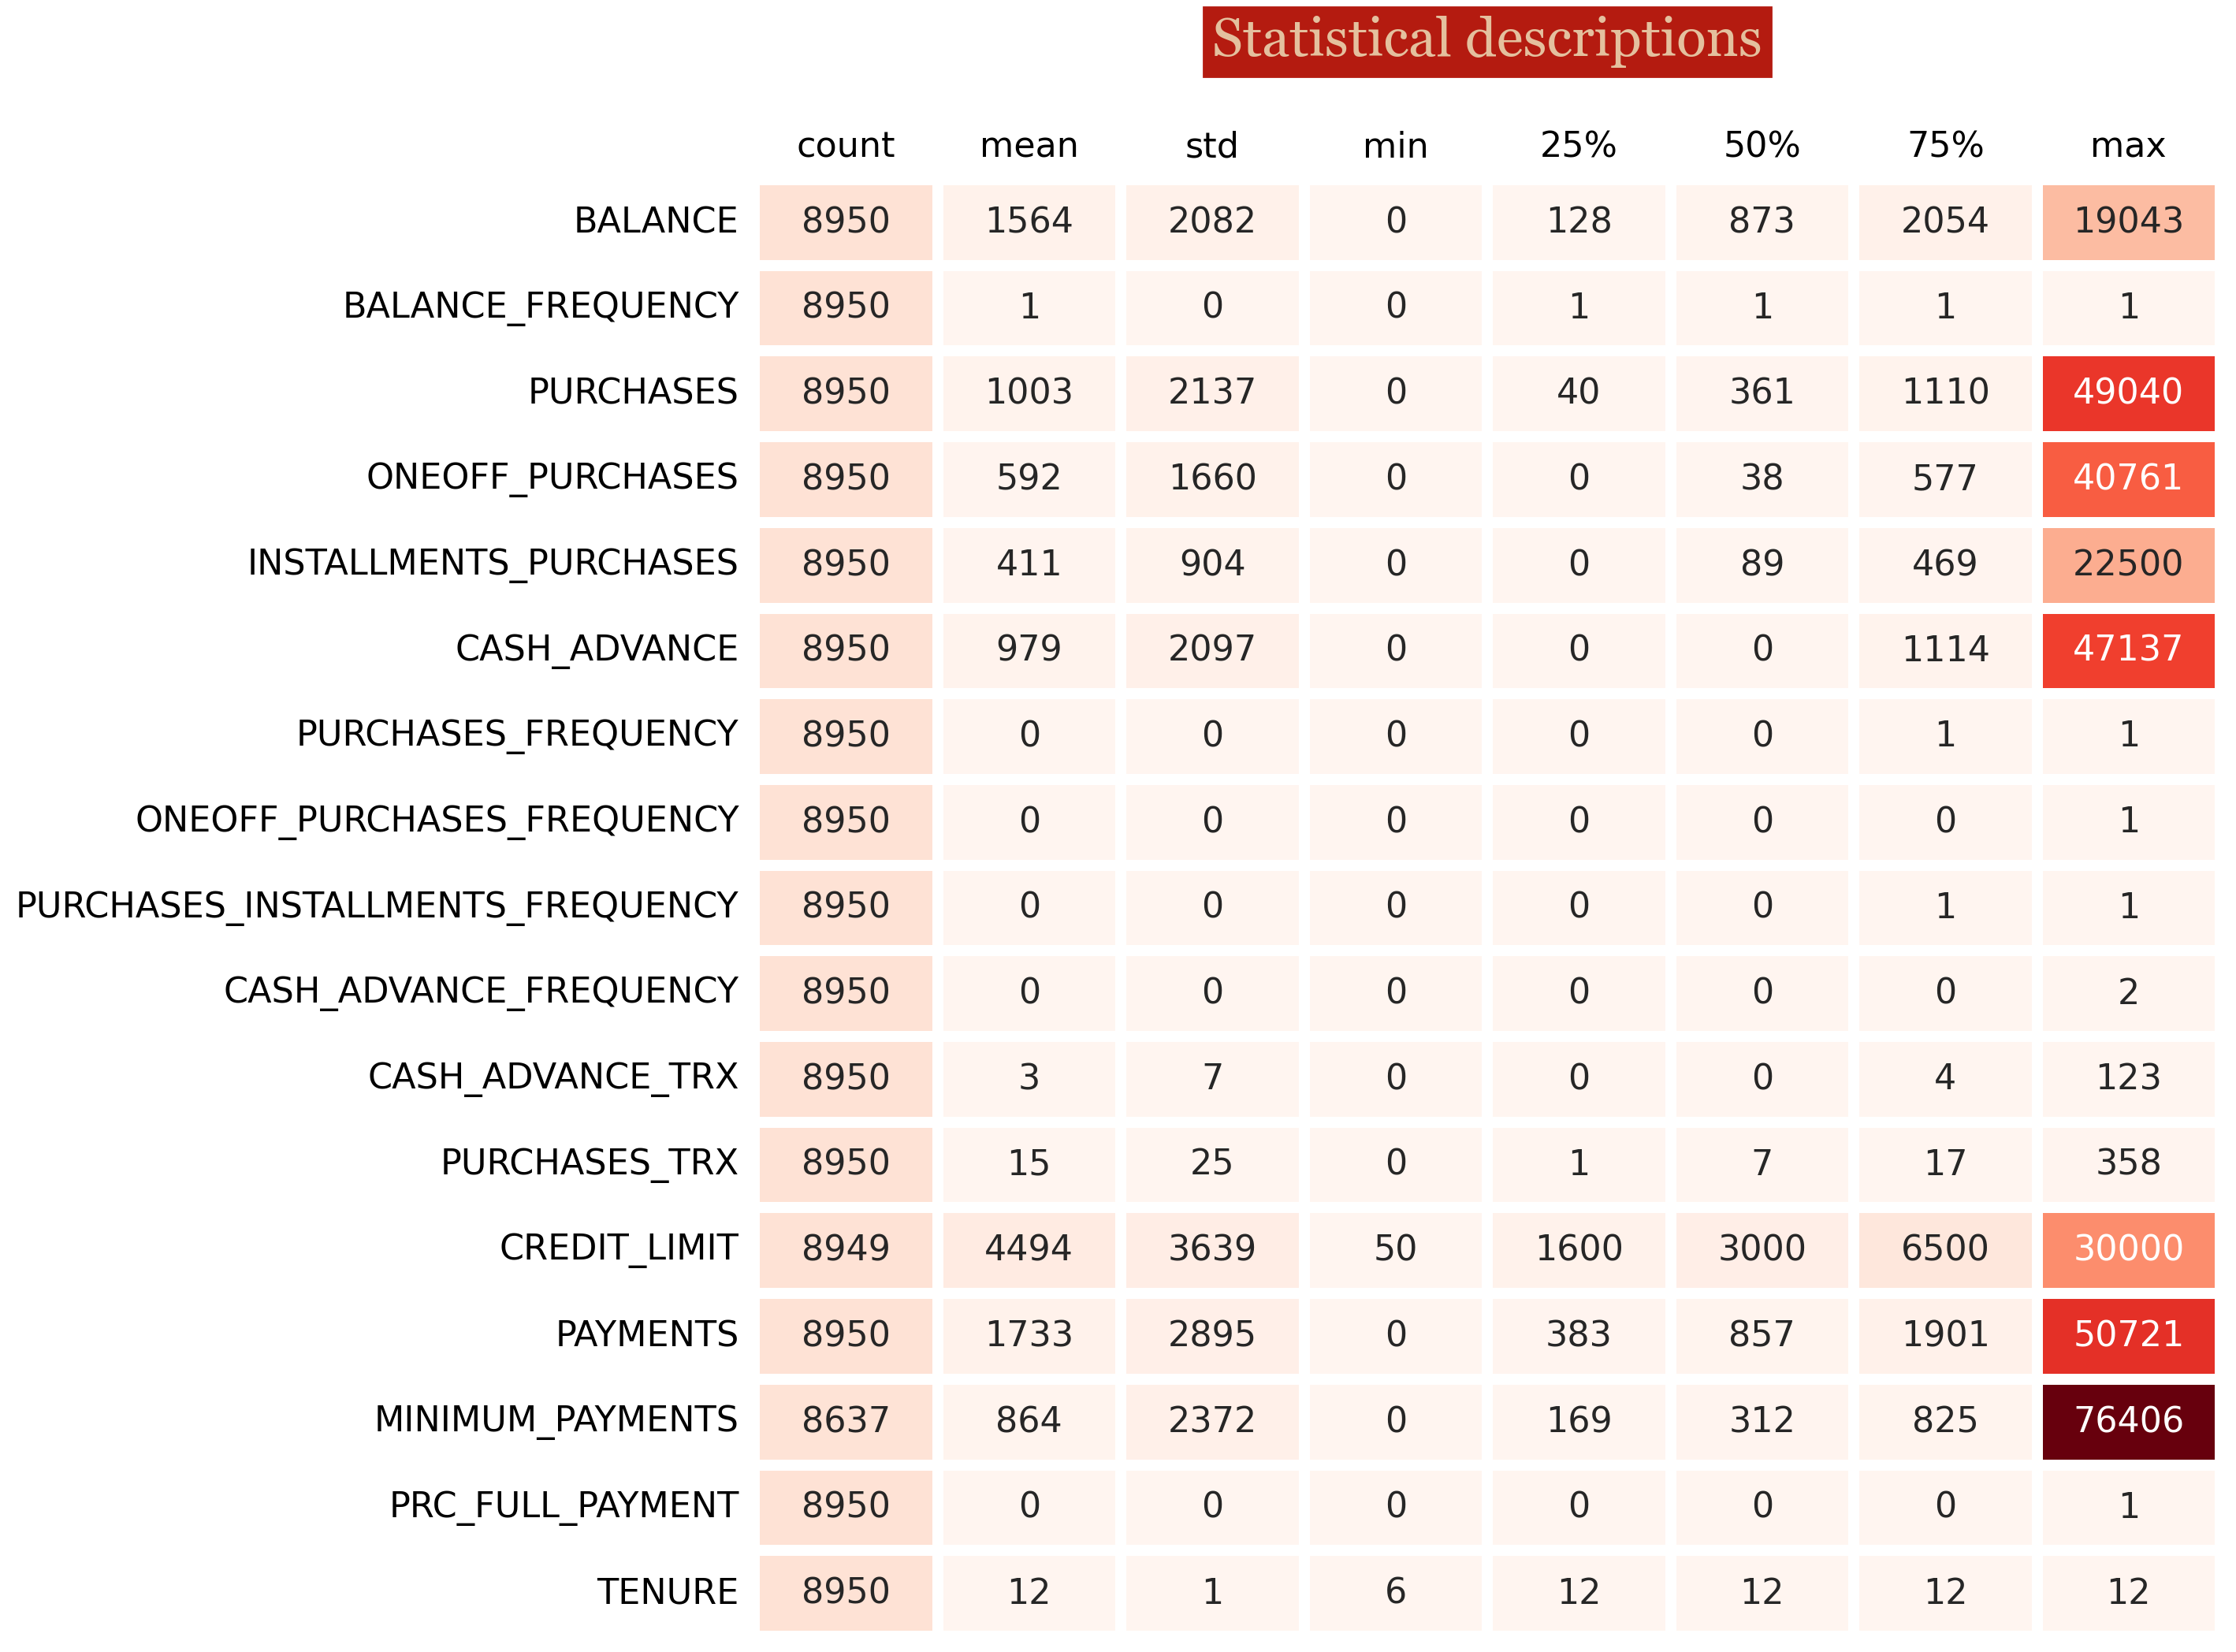

In [75]:
desc_cust = df.select_dtypes(include=['int64','float64']).describe().T


desc_cust_df = pd.DataFrame(index=desc_cust.index, columns=desc_cust.columns, data=desc_cust )


f, ax = plt.subplots(figsize=(12,12), dpi=200)

sns.heatmap(desc_cust_df, annot=True, cmap="Reds", fmt='.0f', ax=ax, linewidths=5, cbar=False, annot_kws={"size": 16})


ax.xaxis.set_ticks_position('top')

plt.tick_params(left=False, top=False)

plt.xticks(size=16)
plt.yticks(size=16)

plt.title("Statistical descriptions", pad=50, x=0.50, y=1.01, fontdict=FONT)

plt.show()

In [76]:
def highlight_cells(val):
    f_color = '#D63226' if val != 0 else ''  
    bg_color = '#BDE0FE' if val != 0 else ''  
    w_font = 'bold'
    return 'background-color: {}; color: {}; font-weight: {}'.format(bg_color, f_color, w_font)


is_nan = df.isna().sum().to_frame(name='Number_of_NaN')
is_nan.insert(1,'Percent(%)', [round(x/df.shape[0]*100,2) for x in is_nan.Number_of_NaN])
is_nan.style.applymap(highlight_cells)

,Number_of_NaN,Percent(%)
CUST_ID,0,0.000000
BALANCE,0,0.000000
BALANCE_FREQUENCY,0,0.000000
PURCHASES,0,0.000000
ONEOFF_PURCHASES,0,0.000000
INSTALLMENTS_PURCHASES,0,0.000000
CASH_ADVANCE,0,0.000000
PURCHASES_FREQUENCY,0,0.000000
ONEOFF_PURCHASES_FREQUENCY,0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0,0.000000


In [77]:
df[df.MINIMUM_PAYMENTS.isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.671,0.636,1499.000,1499.000,0.000,205.788,0.083,0.083,0.000,0.083,1,1,7500.000,0.000,NaN,0.000,12
45,C10047,2242.312,1.000,437.000,97.000,340.000,184.649,0.333,0.083,0.333,0.167,2,5,2400.000,0.000,NaN,0.000,12
47,C10049,3910.111,1.000,0.000,0.000,0.000,1980.873,0.000,0.000,0.000,0.500,7,0,4200.000,0.000,NaN,0.000,12
54,C10056,6.661,0.636,310.000,0.000,310.000,0.000,0.667,0.000,0.667,0.000,0,8,1000.000,417.017,NaN,0.000,12
55,C10057,1311.996,1.000,1283.900,1283.900,0.000,0.000,0.250,0.250,0.000,0.000,0,6,6000.000,0.000,NaN,0.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.525,0.333,152.000,152.000,0.000,0.000,0.333,0.333,0.000,0.000,0,2,1500.000,0.000,NaN,0.000,6
8929,C19170,371.527,0.333,0.000,0.000,0.000,1465.408,0.000,0.000,0.000,0.167,5,0,1500.000,0.000,NaN,0.000,6
8935,C19176,183.817,1.000,465.900,0.000,465.900,0.000,1.000,0.000,0.833,0.000,0,6,1500.000,0.000,NaN,0.000,6
8944,C19185,193.572,0.833,1012.730,1012.730,0.000,0.000,0.333,0.333,0.000,0.000,0,2,4000.000,0.000,NaN,0.000,6


In [81]:
df[df.CREDIT_LIMIT.isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400,0.167,0.000,0.000,0.000,186.853,0.000,0.000,0.000,0.167,1,0,NaN,9.040,14.419,0.000,6


In [82]:
df = df.drop(df[df.CREDIT_LIMIT.isna()].index, axis=0)

In [83]:
df[df.MINIMUM_PAYMENTS.isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.671,0.636,1499.000,1499.000,0.000,205.788,0.083,0.083,0.000,0.083,1,1,7500.000,0.000,NaN,0.000,12
45,C10047,2242.312,1.000,437.000,97.000,340.000,184.649,0.333,0.083,0.333,0.167,2,5,2400.000,0.000,NaN,0.000,12
47,C10049,3910.111,1.000,0.000,0.000,0.000,1980.873,0.000,0.000,0.000,0.500,7,0,4200.000,0.000,NaN,0.000,12
54,C10056,6.661,0.636,310.000,0.000,310.000,0.000,0.667,0.000,0.667,0.000,0,8,1000.000,417.017,NaN,0.000,12
55,C10057,1311.996,1.000,1283.900,1283.900,0.000,0.000,0.250,0.250,0.000,0.000,0,6,6000.000,0.000,NaN,0.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.525,0.333,152.000,152.000,0.000,0.000,0.333,0.333,0.000,0.000,0,2,1500.000,0.000,NaN,0.000,6
8929,C19170,371.527,0.333,0.000,0.000,0.000,1465.408,0.000,0.000,0.000,0.167,5,0,1500.000,0.000,NaN,0.000,6
8935,C19176,183.817,1.000,465.900,0.000,465.900,0.000,1.000,0.000,0.833,0.000,0,6,1500.000,0.000,NaN,0.000,6
8944,C19185,193.572,0.833,1012.730,1012.730,0.000,0.000,0.333,0.333,0.000,0.000,0,2,4000.000,0.000,NaN,0.000,6
